## Pastas

In dit notebook staat een voorbeeld hoe je de `observation` package kan gebruiken om een `pastastore` te maken. Een `pastastore` is een verzameling van meetreeksen, verklarende reeksen en tijdreeksmodellen.

In [1]:
import pastastore as pst
import pandas as pd
from observations import ObsCollection
from observations.io import io_knmi
from observations.observation import KnmiObs

### oseries
Als eerste downloaden we een aantal meetreeksen van dinoloket door een extent op te geven.

In [2]:
extent = [117850, 117980, 439550, 439700]  # Schoonhoven zuid-west
oc_dino = ObsCollection.from_dino(extent=extent, keep_all_obs=False, verbose=True, cache=True)
oc_dino


download grondwatermonitoring data from dino within:
- extent: [117850, 117980, 439550, 439700] or
- bbox: None
reading -> B38B0070-001
not added to collection -> B38B0070-001
reading -> B38B0069-001
not added to collection -> B38B0069-001
reading -> B38B0206-001
reading -> B38B0206-002
reading -> B38B0207-001


,x,y,filename,locatie,filternr,bovenkant_filter,onderkant_filter,maaiveld,meetpunt,metadata_available,obs
name,,,,,,,,,,,
B38B0206-001,117893,439652,,B38B0206,1,-2.04,-3.04,-0.08,NaN,True,stand_m_tov_nap remarks 1985-03-28...
B38B0206-002,117893,439652,,B38B0206,2,-14.00,-15.00,-0.08,NaN,True,stand_m_tov_nap remarks 1985-03-28...
B38B0207-001,117960,439670,,B38B0207,1,NaN,-38.67,-0.87,NaN,True,stand_m_tov_nap remarks 1985-02-28...


Deze meetreeksen voegen we toe aan het pastas project (oude methode).

In [3]:
pr = oc_dino.to_pastas_project(verbose=True)

INFO: Cannot determine frequency of series B38B0206-001
INFO: Cannot determine frequency of series B38B0206-002
INFO: Cannot determine frequency of series B38B0207-001


add to pastas project -> B38B0206-001
did not add clusterId to metadata because datatype is <class 'NoneType'>
did not add clusterList to metadata because datatype is <class 'NoneType'>
add to pastas project -> B38B0206-002
did not add clusterId to metadata because datatype is <class 'NoneType'>
did not add clusterList to metadata because datatype is <class 'NoneType'>
add to pastas project -> B38B0207-001
did not add topDepthMv to metadata because datatype is <class 'NoneType'>
did not add clusterId to metadata because datatype is <class 'NoneType'>
did not add clusterList to metadata because datatype is <class 'NoneType'>
did not add startDepthNap to metadata because datatype is <class 'NoneType'>
did not add startDepthMv to metadata because datatype is <class 'NoneType'>
did not add startDateSamples to metadata because datatype is <class 'NoneType'>
did not add endDateSamples to metadata because datatype is <class 'NoneType'>
did not add bovenkant_filter to metadata because datatype

In [4]:
pr.oseries.columns

Index(['name', 'series', 'kind', 'x', 'y', 'z', 'projection', 'topDepthMv',
       'bottomDepthMv', 'diver', 'startDate', 'endDate', 'headCount',
       'stCount', 'saCount', 'crs', 'startDepthNap', 'endDepthNap',
       'startDepthMv', 'endDepthMv', 'startDateLevels', 'endDateLevels',
       'startDateSamples', 'endDateSamples', 'filename', 'locatie', 'filternr',
       'bovenkant_filter', 'onderkant_filter', 'maaiveld', 'meetpunt',
       'metadata_available', 'sampleCount'],
      dtype='object')

### Stresses

Voeg knmi data toe.

In [13]:
tmin = pr.oseries['startDate'].min()
tmax = pr.oseries['endDate'].max()
meteo_types=('RD', 'EV24')
knmi_oc = ObsCollection.from_knmi(oc_dino, meteo_types=meteo_types,
                                  start=(tmin, tmin), end=(tmax,tmax), 
                                  cache=True,
                                  verbose=True)

kinds = ('prec', 'evap')
for i, meteo_var in enumerate(meteo_types):
    knmi_oc[knmi_oc.index.str.startswith(meteo_var)].to_pastas_project(pr, obs_column=meteo_var, 
                                                                       kind=kinds[i], verbose=True)

reading 434-RD from cache
reading 348-EV24 from cache


### Voeg neerslag toe en maak modellen

In [15]:
mls = pr.add_models()
pr.add_recharge()

### solve models

In [16]:
pr.solve_models()

### bekijk resultaat

In [10]:
pr.get_statistics(['evp'])

B38B0206-001    31.005810
B38B0206-002    22.885656
B38B0207-001    17.389815
Name: evp, dtype: float64

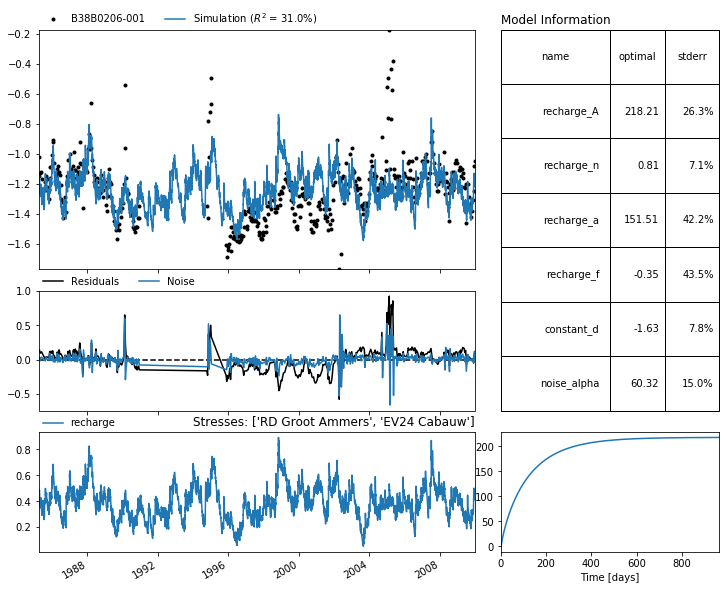

In [11]:
ml1 = pr.models['B38B0206-001']
ml1.plots.results()

# Nieuwe methode met een pastastore:

### oseries

In [20]:
pstore = oc_dino.to_pastastore()

In [21]:
pstore.conn.get_oseries('B38B0206-001')

1985-03-28   -1.15
1985-04-15   -1.02
1985-04-29   -1.13
1985-05-14   -1.12
1985-05-28   -1.17
              ... 
2009-10-28   -1.38
2009-11-13   -1.31
2009-11-27   -1.25
2009-12-14   -1.08
2009-12-28   -1.05
Name: stand_m_tov_nap, Length: 470, dtype: float64

### stresses

In [22]:
tmin = pstore.conn.oseries['startDate'].min()
tmax = pstore.conn.oseries['endDate'].max()

In [23]:
for i, meteo_var in enumerate(meteo_types):
    knmi_oc[knmi_oc.index.str.startswith(meteo_var)].to_pastastore(pstore, obs_column=meteo_var, 
                                                                   kind=kinds[i], verbose=True)

In [24]:
pstore.conn.stresses

,x,y,STN,YYYYMMDD,RD,SX,filename,kind,EV24
name,,,,,,,,,
RD Groot Ammers,115722.518086,436511.749355,stationsnummer/stationnumber,datum/date (YYYY=jaar/year MM=maand/month DD=d...,24-uur som van de neerslag in m van 08.00 voor...,codecijfer sneeuwdek om 08.00 uur UTC/code for...,,prec,NaN
EV24 Cabauw,122637.550043,442024.536029,NaN,Date (YYYY=year MM=month DD=day);,NaN,NaN,,evap,Potential evapotranspiration (Makkink) (in m);


### recharge, solve en results

In [25]:
pstore.create_models(store=True, add_recharge=True, ignore_errors=False)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]INFO: Cannot determine frequency of series B38B0206-001
INFO: Inferred frequency from time series RD Groot Ammers: freq=D 
INFO: Inferred frequency from time series EV24 Cabauw: freq=D 
 33%|████████████████████████████                                                        | 1/3 [00:00<00:00,  8.71it/s]INFO: Cannot determine frequency of series B38B0206-002
INFO: Inferred frequency from time series RD Groot Ammers: freq=D 
INFO: Inferred frequency from time series EV24 Cabauw: freq=D 
 67%|████████████████████████████████████████████████████████                            | 2/3 [00:00<00:00,  8.81it/s]INFO: Cannot determine frequency of series B38B0207-001
INFO: Inferred frequency from time series RD Groot Ammers: freq=D 
INFO: Inferred frequency from time series EV24 Cabauw: freq=D 
100%|████████████████████████████████████████████████████████████████████████████████

[]

In [26]:
pstore.conn

<DictConnector object> 'my_conn': 3 oseries, 2 stresses, 3 models

In [27]:
pstore.solve_models()

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.33it/s]


In [28]:
pstore.model_results()

flopy is installed in C:\Anaconda3\envs\dev\lib\site-packages\flopy


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.55it/s]


,recharge_A,recharge_n,recharge_a,recharge_f,constant_d,noise_alpha,recharge_A_stderr,recharge_n_stderr,recharge_a_stderr,recharge_f_stderr,constant_d_stderr,noise_alpha_stderr,evp,number of observations used in calibration,memory recharge [days],rfunc recharge,calibration period [days]
B38B0206-001,218.21,0.805978,151.513,-0.353798,-1.62976,60.3201,57.4079,0.0571354,63.9243,0.15389,0.127234,9.03048,31.0058,NaN,296.402,Gamma,9041
B38B0206-002,118.309,0.660337,58.3971,-0.270871,-0.968043,18.4091,26.727,0.0725284,27.9101,0.150144,0.0700819,2.1053,22.8857,NaN,98.1235,Gamma,9041
B38B0207-001,60.4322,0.857394,9.50818,-0.146873,-1.87974,16.7987,19.9099,0.269249,7.55543,0.392219,0.0707821,3.73922,17.3898,NaN,19.4928,Gamma,2115


INFO: Cannot determine frequency of series B38B0206-001


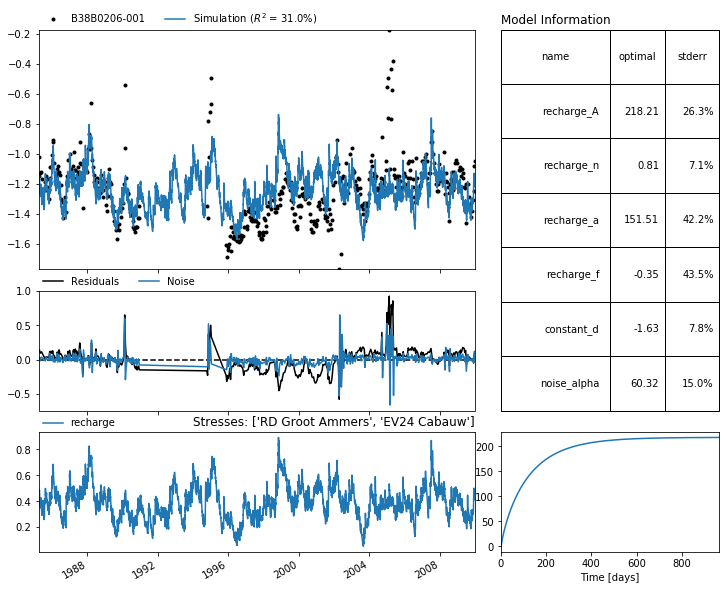

In [29]:
ml1 = pstore.conn.get_models('B38B0206-001')
ml1.plots.results()